In [1]:
import torch
import matplotlib.pyplot as plt

$p(x) = 1 - 2x^2$

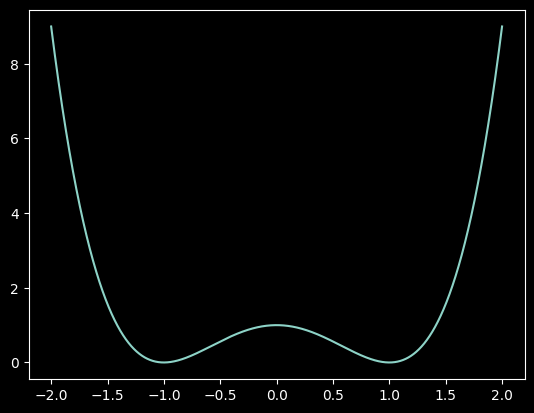

In [20]:
x = torch.linspace(-2,2,10000).reshape((-1,1))
def f(x): return 1 - 2 * x ** 2 + x ** 4
y = f(x)
plt.plot(x, y);

In [21]:
W1 = torch.randn((1, 6))
b1 = torch.randn((6))
W2 = torch.randn((5, 6))
b2 = torch.randn((6))
W3 = torch.randn((5, 1))
b3 = torch.randn((1))
pre_z1 = x @ W1 + b1
z1 = torch.cat((pre_z1[:, 0][:, None], torch.sin(pre_z1[:, 1][:, None]), torch.cos(
    pre_z1[:, 2][:, None]), torch.sigmoid(pre_z1[:, 3][:, None]), pre_z1[:, 4][:, None] * pre_z1[:, 5][:, None]), 1)
pre_z2 = z1 @ W2 + b2
z2 = torch.cat((pre_z2[:, 0][:, None], torch.sin(pre_z2[:, 1][:, None]), torch.cos(
    pre_z2[:, 2][:, None]), torch.sigmoid(pre_z2[:, 3][:, None]), pre_z2[:, 4][:, None] * pre_z2[:, 5][:, None]), 1)
y_hat = z2 @ W3 + b3
parameters = [W1, b1, W2, b2, W3, b3]
y_hat.shape

torch.Size([10000, 1])

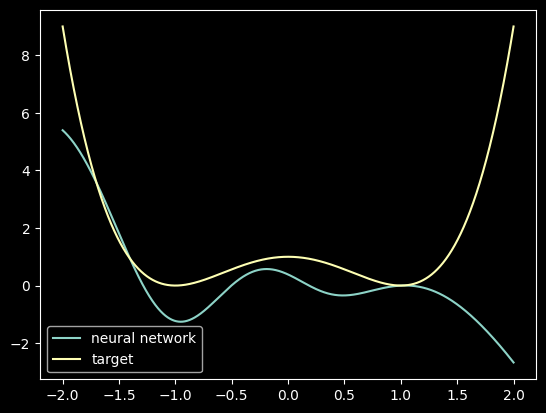

In [22]:
plt.plot(x, y_hat, label='neural network')
plt.plot(x, y, label='target')
plt.legend();

In [23]:
# regularization = 0.1
# norm = torch.zeros((1))
# for p in parameters:
#     norm += p.abs().sum()
loss = ((y_hat- y) ** 2).mean(0) # + regularization * sum([p.abs().sum() for p in parameters])
loss

tensor([6.3999])

In [38]:
regularization = 0
for p in parameters:
    p.requires_grad = True
    
def forward(x, parameters):
    W1, b1, W2, b2, W3, b3 = parameters
    pre_z1 = x @ W1 + b1
    z1 = torch.cat((pre_z1[:, 0][:, None], torch.sin(pre_z1[:, 1][:, None]), torch.cos(
        pre_z1[:, 2][:, None]), torch.sigmoid(pre_z1[:, 3][:, None]), pre_z1[:, 4][:, None] * pre_z1[:, 5][:, None]), 1)
    pre_z2 = z1 @ W2 + b2
    z2 = torch.cat((pre_z2[:, 0][:, None], torch.sin(pre_z2[:, 1][:, None]), torch.cos(
        pre_z2[:, 2][:, None]), torch.sigmoid(pre_z2[:, 3][:, None]), pre_z2[:, 4][:, None] * pre_z2[:, 5][:, None]), 1)
    y_hat = z2 @ W3 + b3
    return y_hat
    
learning_rate = 0.01
batch_size = 32
for _ in range(100):
    for p in parameters:
        with torch.no_grad():
            p[p.abs() < 0.01] = 0.0

    ix = torch.randint(0,len(x), (batch_size,))
    x_batch = x[ix]
    y_batch = y[ix]


    y_hat = forward(x_batch, parameters)

    loss = ((y_hat - y_batch) ** 2).mean(0) + regularization * \
        sum([p.abs().sum() for p in parameters])

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        with torch.no_grad():
            p += -learning_rate * p.grad
    print(loss)


tensor([0.0255], grad_fn=<AddBackward0>)
tensor([0.0316], grad_fn=<AddBackward0>)
tensor([0.0361], grad_fn=<AddBackward0>)
tensor([0.0503], grad_fn=<AddBackward0>)
tensor([0.0733], grad_fn=<AddBackward0>)
tensor([0.0822], grad_fn=<AddBackward0>)
tensor([0.0376], grad_fn=<AddBackward0>)
tensor([0.0456], grad_fn=<AddBackward0>)
tensor([0.0312], grad_fn=<AddBackward0>)
tensor([0.0357], grad_fn=<AddBackward0>)
tensor([0.0153], grad_fn=<AddBackward0>)
tensor([0.0193], grad_fn=<AddBackward0>)
tensor([0.0119], grad_fn=<AddBackward0>)
tensor([0.0408], grad_fn=<AddBackward0>)
tensor([0.0421], grad_fn=<AddBackward0>)
tensor([0.1036], grad_fn=<AddBackward0>)
tensor([0.2787], grad_fn=<AddBackward0>)
tensor([1.3782], grad_fn=<AddBackward0>)
tensor([3.8713], grad_fn=<AddBackward0>)
tensor([5.9198], grad_fn=<AddBackward0>)
tensor([4.0735], grad_fn=<AddBackward0>)
tensor([3.2266], grad_fn=<AddBackward0>)
tensor([0.6782], grad_fn=<AddBackward0>)
tensor([0.1024], grad_fn=<AddBackward0>)
tensor([0.0323],

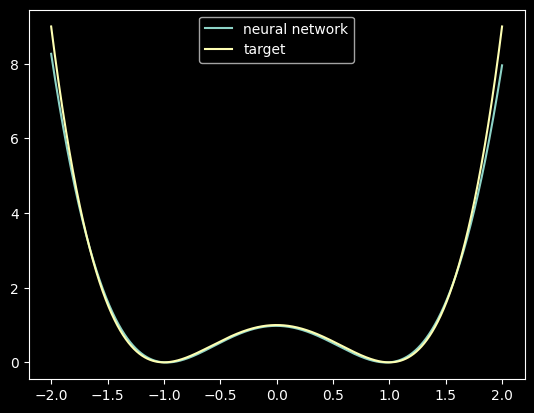

In [39]:
y_hat = forward(x, parameters)
plt.plot(x, y_hat.detach(), label='neural network')
plt.plot(x, y, label='target')
plt.legend();


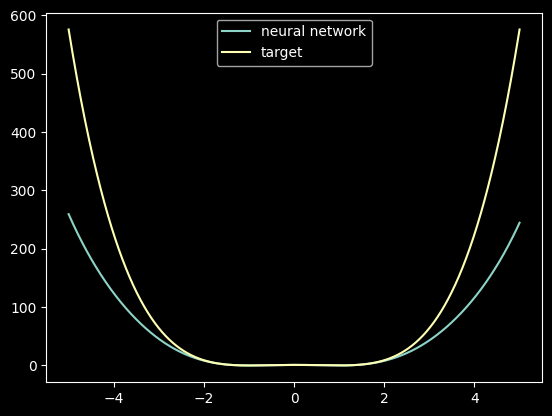

In [40]:
x2 = torch.linspace(-5,5,1000).reshape((-1, 1))
y2 = forward(x2, parameters).detach()

plt.plot(x2, y2, label='neural network')
plt.plot(x2, f(x2), label='target')
plt.legend();


In [41]:
for p in parameters:
    print(p)

tensor([[ 0.0000,  0.0000,  0.9461,  0.0000, -0.9872, -0.9833]],
       requires_grad=True)
tensor([ 0.0000,  0.0000, -3.0923,  0.0000,  0.0058,  0.0509],
       requires_grad=True)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.9415, -0.9083],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0024,  0.0024],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.6111, -0.6181]],
       requires_grad=True)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0048, 0.0047], requires_grad=True)
tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [-1.3092e-03],
        [-6.5462e-04],
        [ 1.1362e+00]], requires_grad=True)
tensor([-0.0013], requires_grad=True)
